In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import get_window
from gwpy.timeseries import TimeSeries
from gwpy.signal import filter_design


/Users/noelsajenmathewsajanmathew/anaconda3/envs/cwb/lib/python3.11/site-packages/gwpy/time/__init__.py:36: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(True)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

  from lal import LIGOTimeGPS


In [2]:
gps= 1266618164
r=1266618180
segment = (int(gps), int(r))
print(segment)

from gwpy.timeseries import TimeSeries
ldata = TimeSeries.fetch_open_data('L1', *segment, verbose=True)
hdata = TimeSeries.fetch_open_data('H1', *segment, verbose=True)
vdata = TimeSeries.fetch_open_data('V1', *segment, verbose=True)

(1266618164, 1266618180)
Fetched 1 URLs from gwosc.org for [1266618164 .. 1266618180))
Reading data... [Done]
Fetched 1 URLs from gwosc.org for [1266618164 .. 1266618180))
Reading data... [Done]
Fetched 1 URLs from gwosc.org for [1266618164 .. 1266618180))
Reading data... [Done]


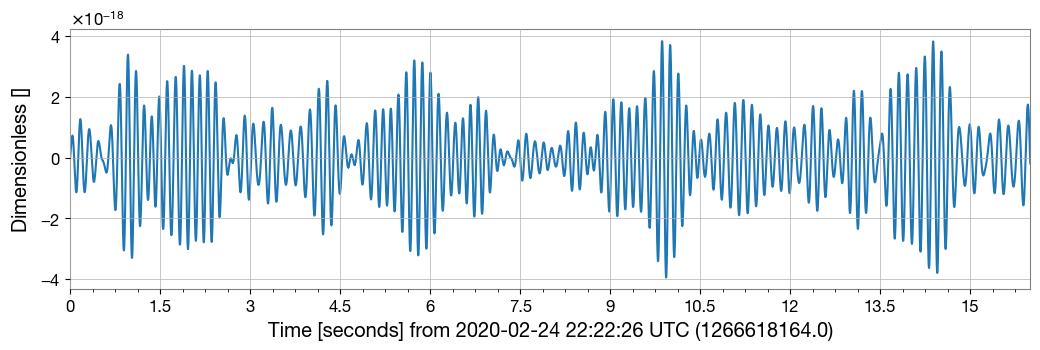

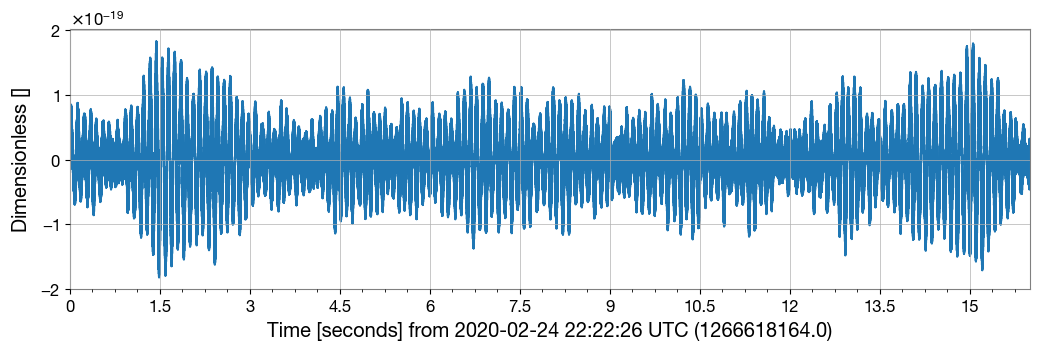

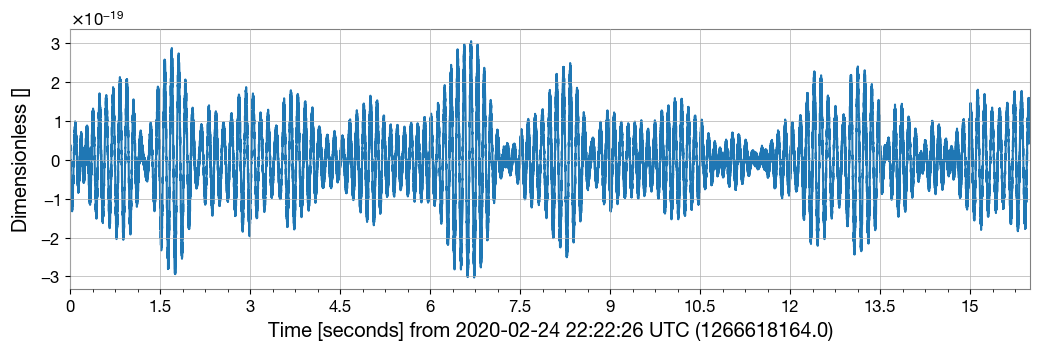

In [3]:
plot = ldata.plot()
plot = hdata.plot()
plot = vdata.plot()

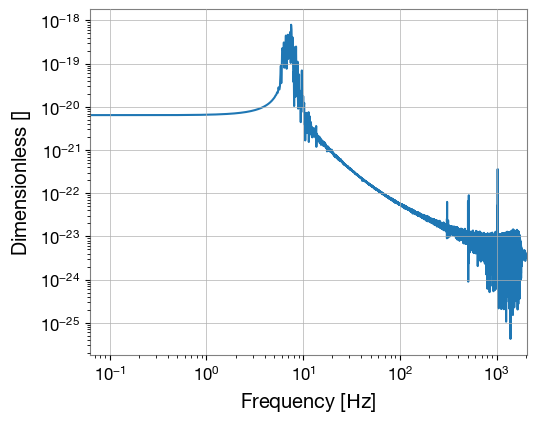

In [4]:
fft = ldata.fft()
plot = fft.abs().plot(xscale="log", yscale="log")
plot.show(warn=False)

In [5]:
from scipy.signal import get_window
window = get_window('hann', ldata.size)
lwin = ldata * window

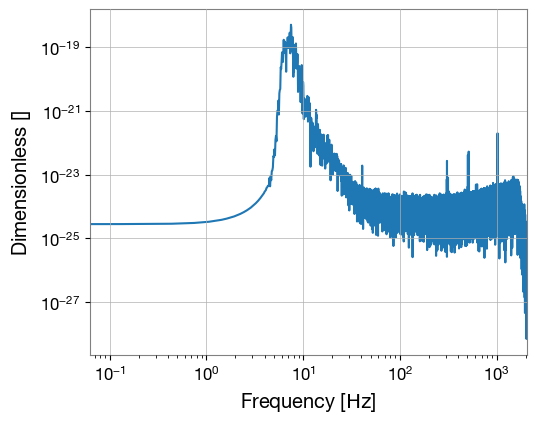

In [6]:
fftamp = lwin.fft().abs()
plot = fftamp.plot(xscale="log", yscale="log")
plot.show(warn=False)

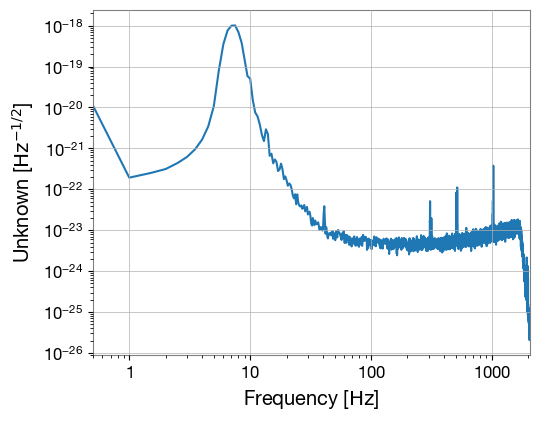

In [7]:
asd = ldata.asd(fftlength=2, method="median")
plot = asd.plot()
plot.show(warn=False)

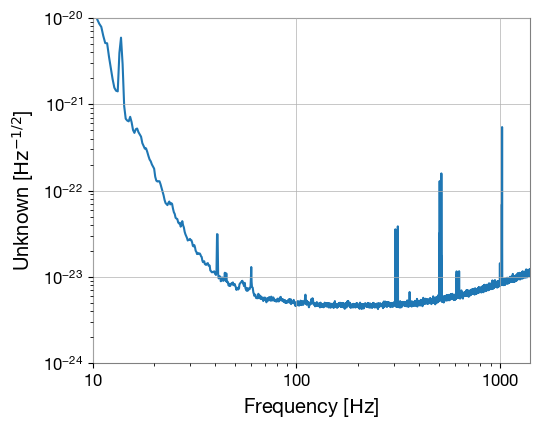

In [8]:
ldata2 = TimeSeries.fetch_open_data('L1', int(gps)-512, int(r)+512, cache=True)
lasd2 = ldata2.asd(fftlength=4, method="median")
plot = lasd2.plot()
ax = plot.gca()
ax.set_xlim(10, 1400)
ax.set_ylim(1e-24, 1e-20)
plot.show(warn=False)

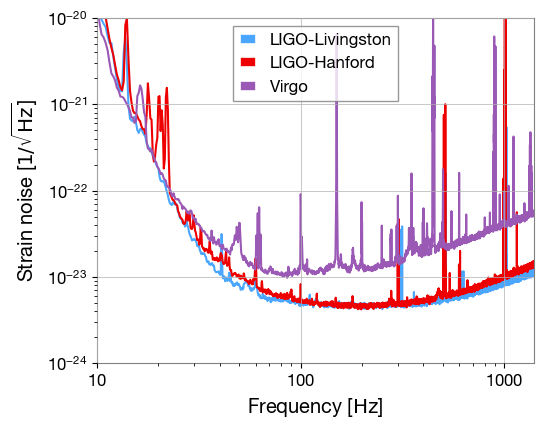

In [9]:
# get Hanford data
hdata2 = TimeSeries.fetch_open_data('H1', int(gps)-512, int(r)+512, cache=True)
hasd2 = hdata2.asd(fftlength=4, method="median")

# get Virgo data
vdata2 = TimeSeries.fetch_open_data('V1', int(gps)-512, int(r)+512, cache=True)
vasd2 = vdata2.asd(fftlength=4, method="median")

# and plot using standard colours
ax.plot(hasd2, label='LIGO-Hanford', color='gwpy:ligo-hanford')
ax.plot(vasd2, label='Virgo', color='gwpy:virgo')

# update the Livingston line to use standard colour, and have a label
lline = ax.lines[0]
lline.set_color('gwpy:ligo-livingston')  # change colour of Livingston data
lline.set_label('LIGO-Livingston')

ax.set_ylabel(r'Strain noise [$1/\sqrt{\mathrm{Hz}}$]')
ax.legend()
plot

In [10]:
import gwpy

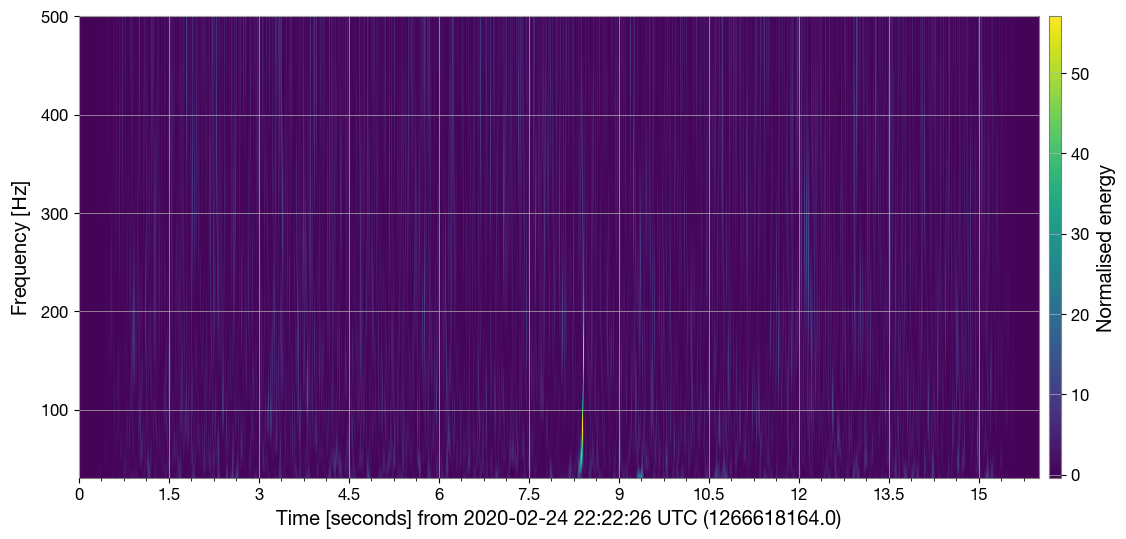

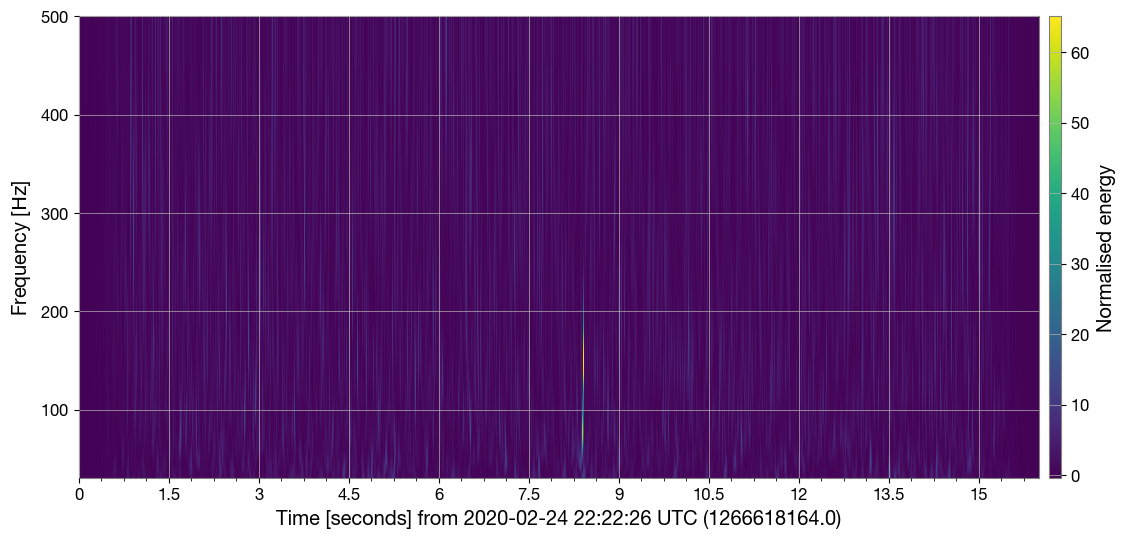

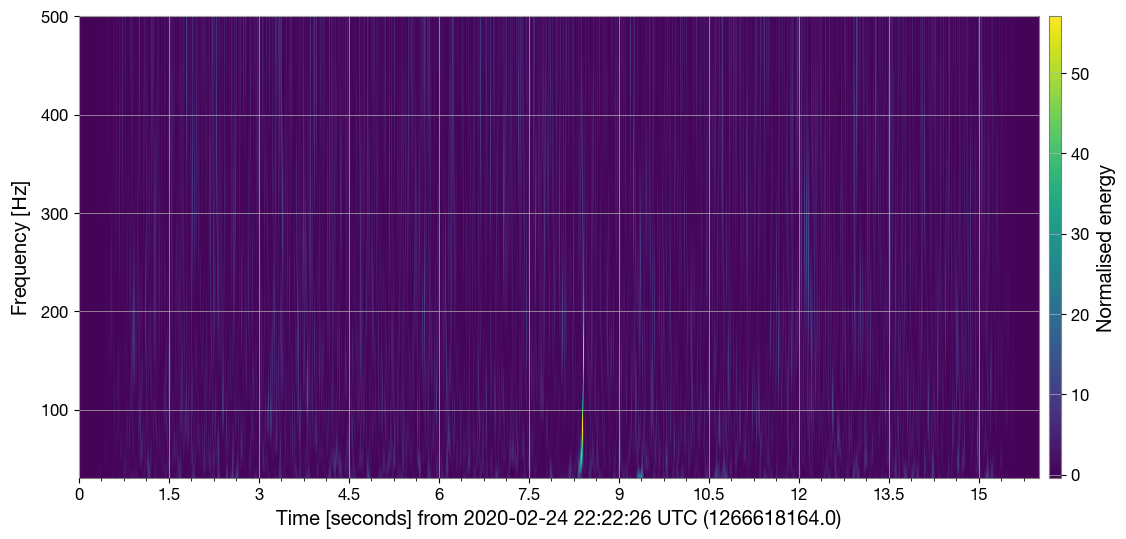

In [11]:
lq = ldata.q_transform(frange=(30, 500))
lplot = lq.plot()
lplot.colorbar(label="Normalised energy")

hq = hdata.q_transform(frange=(30, 500))
hplot = hq.plot()
hplot.colorbar(label="Normalised energy")

vq = vdata.q_transform(frange=(30, 500))
vplot = lq.plot()
vplot.colorbar(label="Normalised energy")


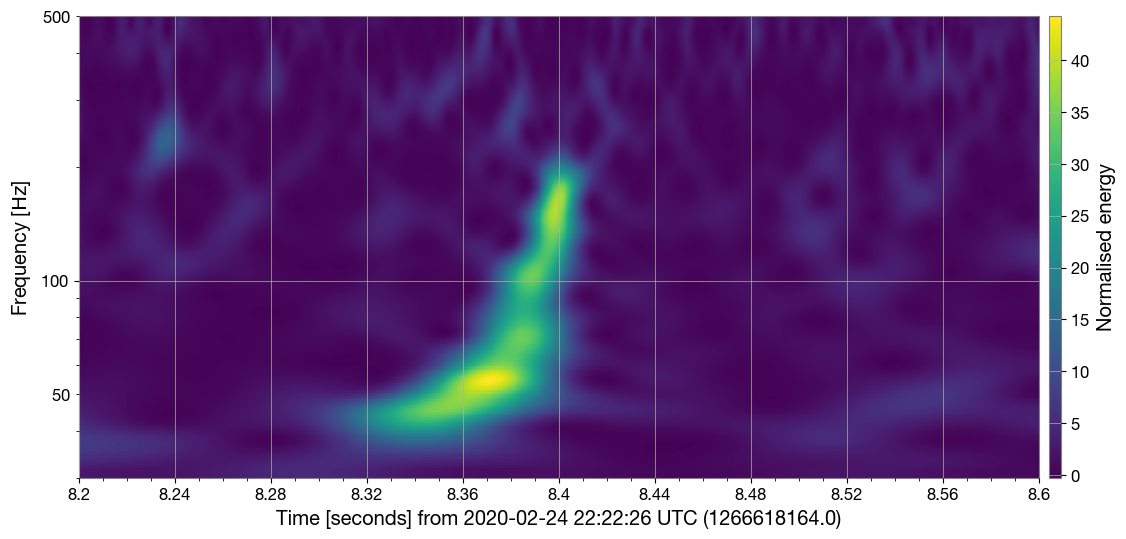

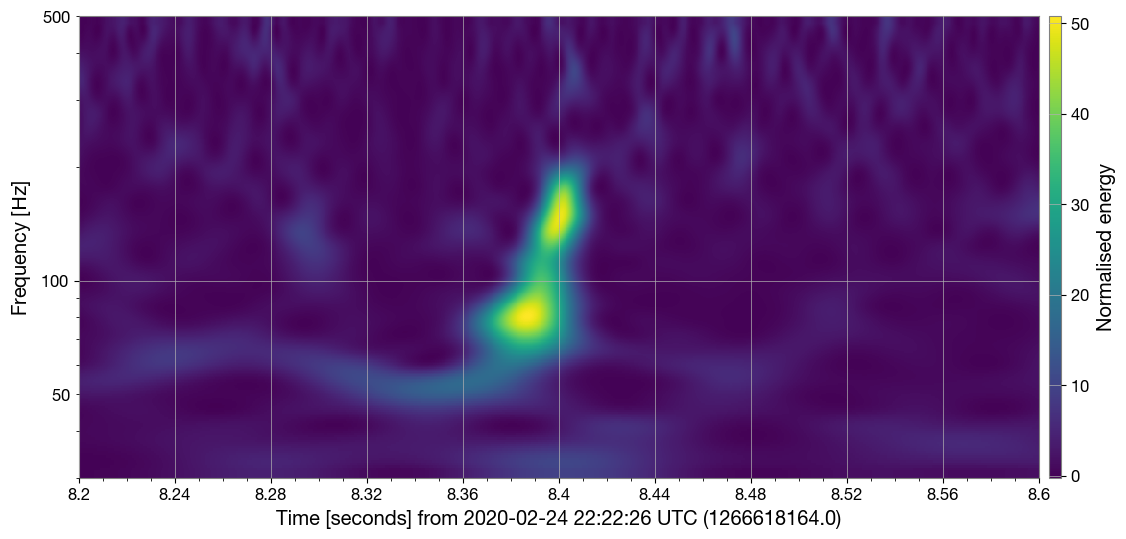

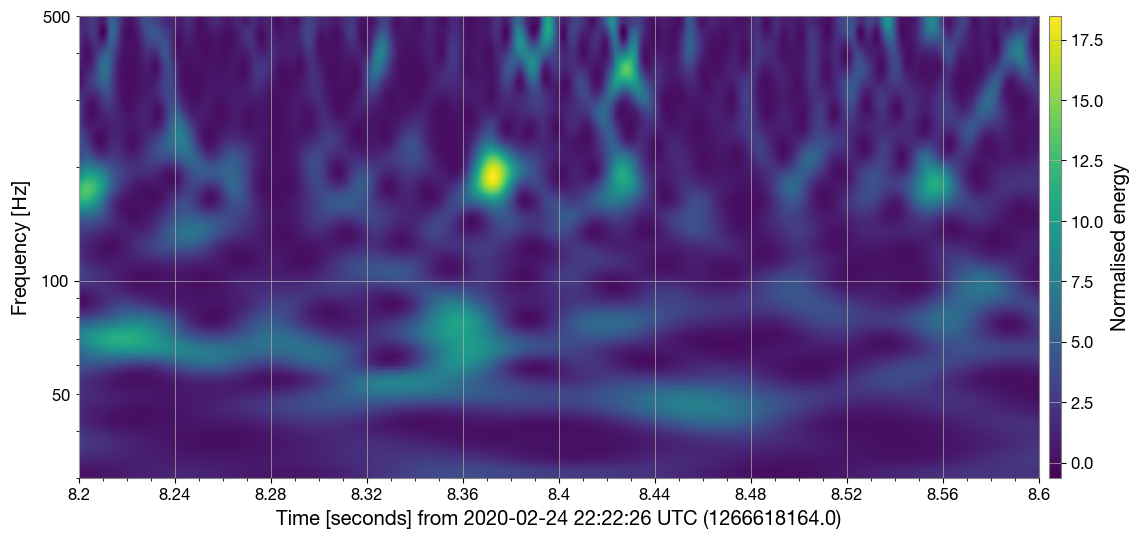

In [12]:
#-- Use OUTSEG for small time range
lq = ldata.q_transform(frange=(30, 500), qrange=(10, 12), outseg=(gps+8.2,gps+8.6)) 
plot = lq.plot()
ax = plot.gca()
ax.set_epoch(gps)
ax.set_yscale('log')
ax.colorbar(label="Normalised energy")

hq = hdata.q_transform(frange=(30, 500), qrange=(10, 12), outseg=(gps+8.2,gps+8.6)) 
plot = hq.plot()
ax = plot.gca()
ax.set_epoch(gps)
ax.set_yscale('log')
ax.colorbar(label="Normalised energy")

vq = vdata.q_transform(frange=(30, 500), qrange=(10, 12), outseg=(gps+8.2,gps+8.6)) 
plot = vq.plot()
ax = plot.gca()
ax.set_epoch(gps)
ax.set_yscale('log')
ax.colorbar(label="Normalised energy")

In [13]:

ldata_white = ldata.whiten(fftlength=4, overlap=2, window=('tukey', 1./4.))
hdata_white = hdata.whiten(fftlength=4, overlap=2, window=('tukey', 1./4.))



In [14]:
mfilter = ldata_white.crop(gps+8.30, gps+8.42)
snr = hdata_white.correlate(mfilter).abs()

/Users/noelsajenmathewsajanmathew/anaconda3/envs/cwb/lib/python3.11/site-packages/gwpy/plot/plot.py:287: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  super().show(warn=warn)


We found a signal at 1266618172.3623047s with SNR 7.0626556806809315


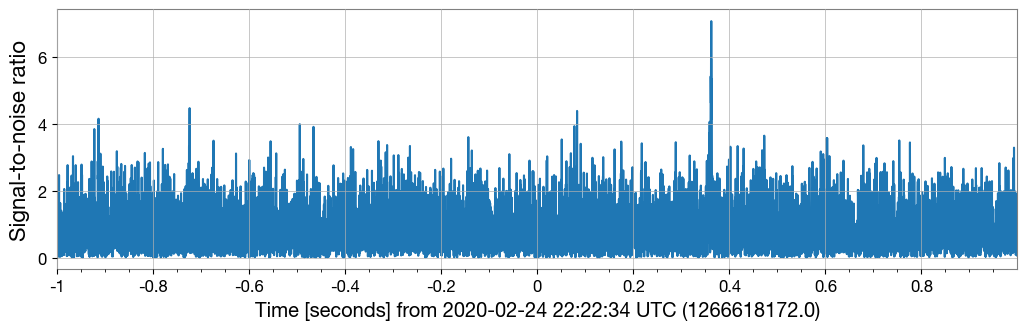

In [15]:
plot = snr.crop(gps+7, gps+9).plot()
plot.axes[0].set_epoch(gps+8)
plot.axes[0].set_ylabel('Signal-to-noise ratio', fontsize=16)
plot.show()

# Find the index of the maximum value in the NumPy array
peak_index = np.abs(snr).argmax()

# Access the time from the TimeSeries object
time = snr.times.value[peak_index]

# Access the peak value from the NumPy array
peak_value = np.abs(snr.value[peak_index])

print("We found a signal at {}s with SNR {}".format(time, peak_value))


In [16]:
bp = filter_design.bandpass(38, 300, hdata.sample_rate)


In [17]:
notches = [filter_design.notch(line, hdata.sample_rate) for
           line in (60, 120, 180)]


In [18]:
zpk = filter_design.concatenate_zpks(bp, *notches)


In [19]:
hfilt = hdata.filter(zpk, filtfilt=True)
hdata = hdata.crop(*hdata.span.contract(1))
hfilt = hfilt.crop(*hfilt.span.contract(1))

We found a signal at 1266618172.3886719s with SNR 4.700938375807614e-22


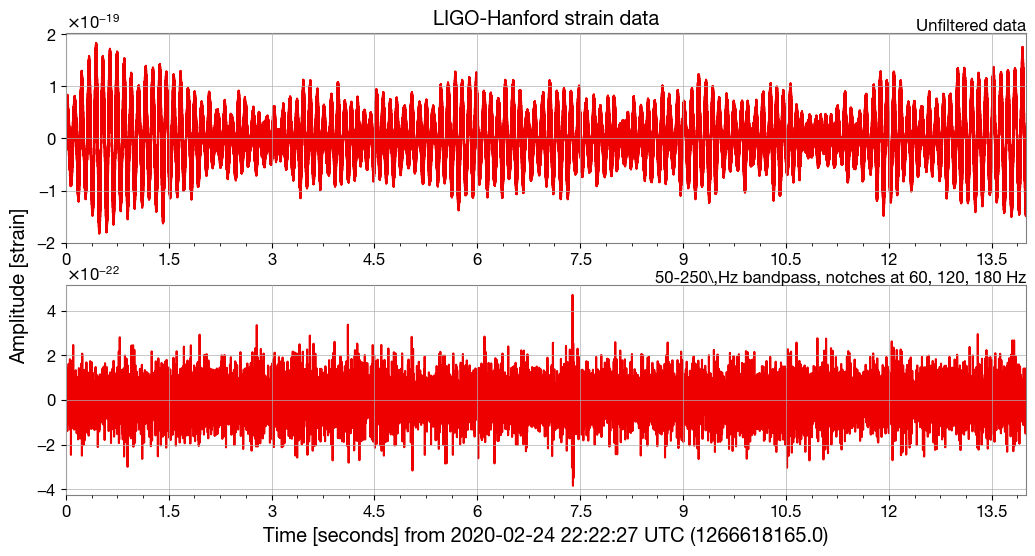

In [20]:
from gwpy.plot import Plot

plot = Plot(hdata, hfilt, figsize=[12, 6], separate=True, sharex=True, color='gwpy:ligo-hanford')
ax1, ax2 = plot.axes
ax1.set_title('LIGO-Hanford strain data')
ax1.text(1.0, 1.01, 'Unfiltered data', transform=ax1.transAxes, ha='right')
ax1.set_ylabel('Amplitude [strain]', y=-0.2)
ax2.set_ylabel('')
ax2.text(1.0, 1.01, r'50-250\,Hz bandpass, notches at 60, 120, 180 Hz', transform=ax2.transAxes, ha='right')
plot.show()

# Find the index of the maximum value in the NumPy array
peak_index = np.abs(hfilt).argmax()

# Access the time from the TimeSeries object
time = hfilt.times.value[peak_index]

# Access the peak value from the NumPy array
peak_value = np.abs(hfilt.value[peak_index])

print("We found a signal at {}s with SNR {}".format(time, peak_value))


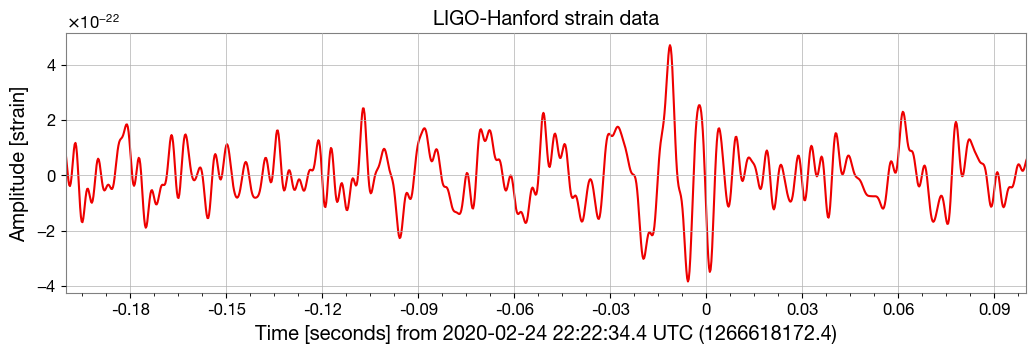

In [21]:
plot = hfilt.plot(color='gwpy:ligo-hanford')
ax = plot.gca()
ax.set_title('LIGO-Hanford strain data')
ax.set_ylabel('Amplitude [strain]')
ax.set_xlim(gps+8.2,gps+8.5)
ax.set_xscale('seconds', epoch=gps+8.4)
plot.show()

In [22]:
lfilt = ldata.filter(zpk, filtfilt=True)
#ldata = ldata.crop(*ldata.span.contract(1))
#lfilt = hfilt.crop(*lfilt.span.contract(1))
lfilt.shift('2.5ms')
lfilt *= -1

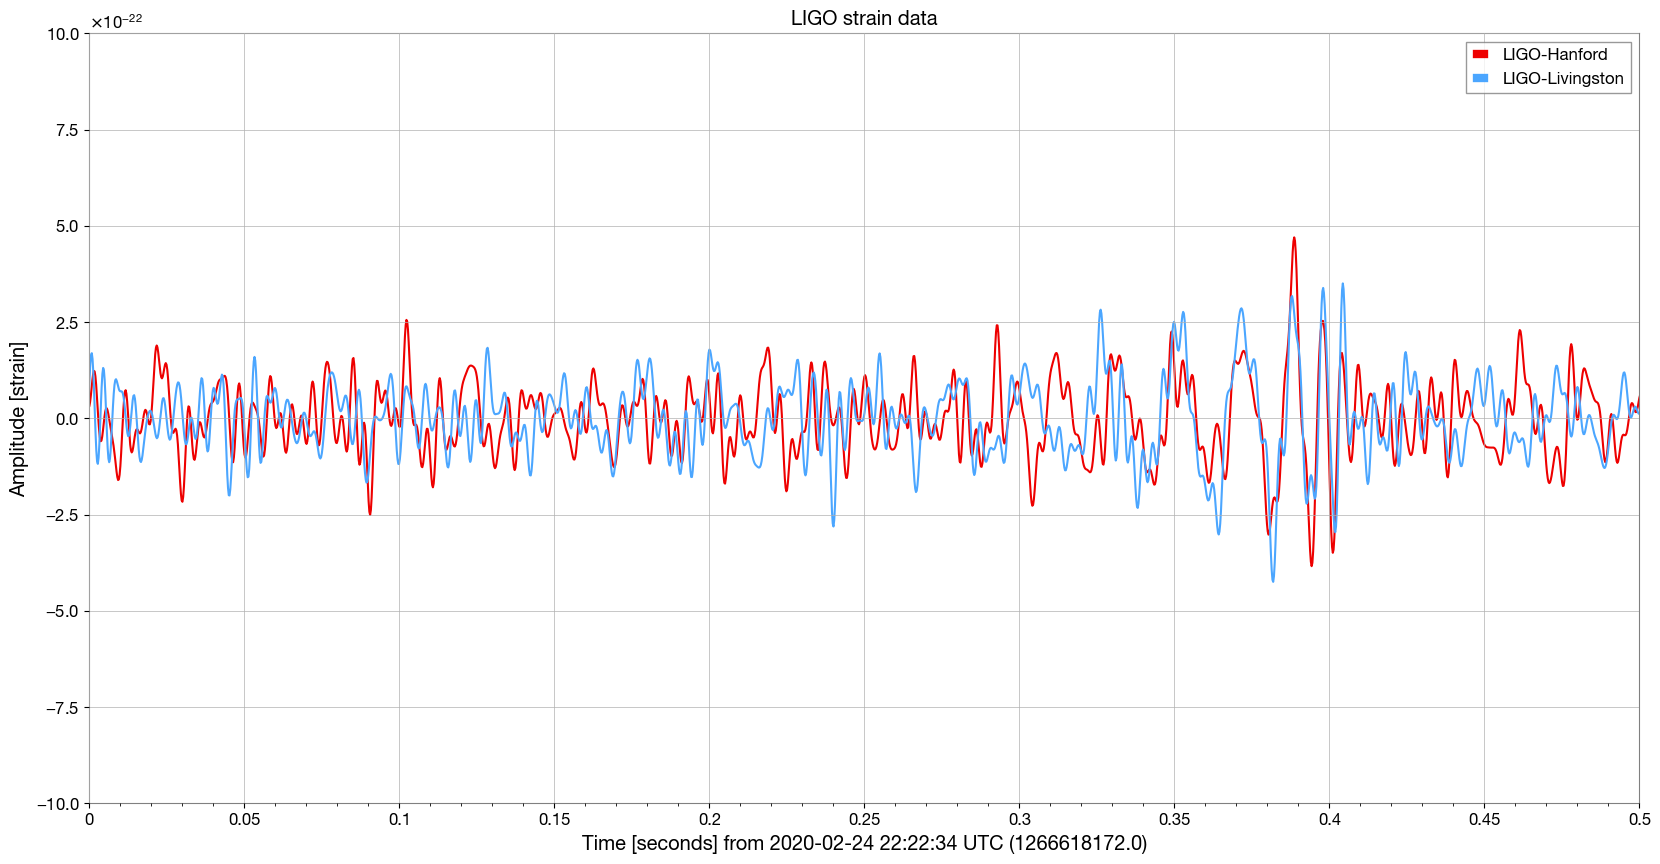

In [23]:
plot = Plot(figsize=[20, 10])
ax = plot.gca()
ax.plot(hfilt, label='LIGO-Hanford', color='gwpy:ligo-hanford')
ax.plot(lfilt, label='LIGO-Livingston', color='gwpy:ligo-livingston')
ax.set_title('LIGO strain data')
ax.set_xlim(gps+8,gps+8.5)
ax.set_xscale('seconds', epoch=gps+8)
ax.set_ylabel('Amplitude [strain]')
ax.set_ylim(-1e-21, 1e-21)
ax.legend()
plot.show()

We found a signal at 1266618172.3596191s with SNR 1.9883211185236158e-21


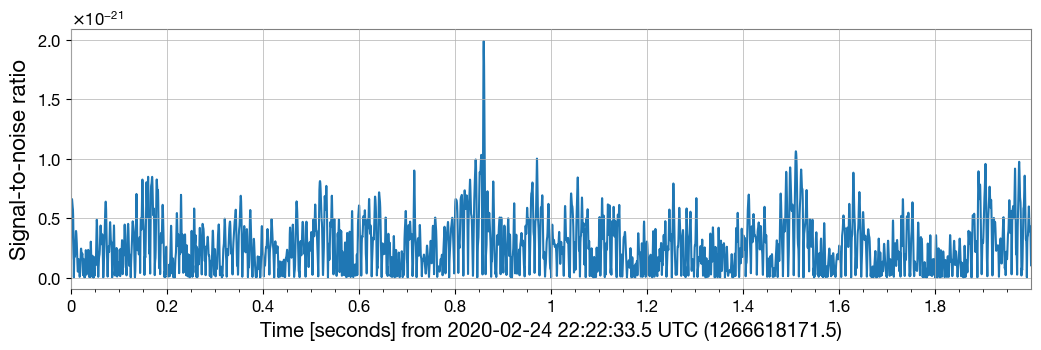

In [24]:
mfilter = lfilt.crop(gps+8.30, gps+8.42)

snr = hfilt.correlate(mfilter).abs()

plot = snr.crop(gps+7.5, gps+9.5).plot()
plot.axes[0].set_epoch(gps+7.5)
plot.axes[0].set_ylabel('Signal-to-noise ratio', fontsize=16)
plot.show()

# Find the index of the maximum value in the NumPy array
peak_index = np.abs(snr).argmax()

# Access the time from the TimeSeries object
time = snr.times.value[peak_index]

# Access the peak value from the NumPy array
peak_value = np.abs(snr.value[peak_index])

print("We found a signal at {}s with SNR {}".format(time, peak_value))


PyCBC.libutils: pkg-config call failed, setting NO_PKGCONFIG=1
/Users/noelsajenmathewsajanmathew/anaconda3/envs/cwb/lib/python3.11/site-packages/gwpy/plot/plot.py:287: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  super().show(warn=warn)


We found a signal at 1266618170.0058594s with SNR 19.56829785953334


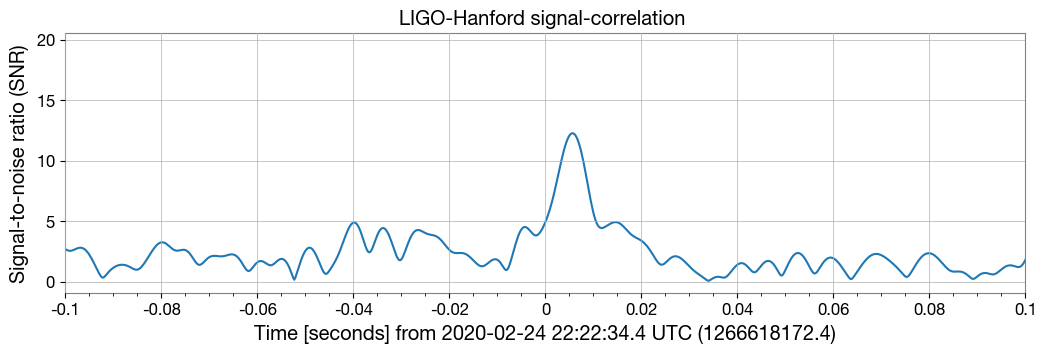

In [25]:
from gwpy.timeseries import TimeSeries
from pycbc.waveform import get_fd_waveform
from pycbc.filter import matched_filter
import numpy as np

data = TimeSeries.fetch_open_data('H1', gps, r)
high = data.highpass(15)
psd = high.psd(4, 2)
zoom = high.crop(gps + 6, r - 6)

hp, _ = get_fd_waveform(approximant="IMRPhenomD", mass1=40, mass2=32.5,
                        f_lower=38, f_final=2048, delta_f=psd.df.value)

snr = matched_filter(hp, zoom.to_pycbc(), psd=psd.to_pycbc(),
                     low_frequency_cutoff=38)
snrts = TimeSeries.from_pycbc(snr).abs()
plot = snrts.plot()
ax = plot.gca()
ax.set_xlim(gps+8.3, gps+8.5)
ax.set_epoch(gps+8.4)
ax.set_ylabel('Signal-to-noise ratio (SNR)')
ax.set_title('LIGO-Hanford signal-correlation ')
plot.show()

# Convert TimeSeries object to a NumPy array
snrts_array = snrts.value

# Find the index of the maximum value in the NumPy array
peak = np.abs(snrts_array).argmax()

# Access the peak value and time from the TimeSeries object
snrp = snrts_array[peak]
time = snrts.times.value[peak]

print("We found a signal at {}s with SNR {}".format(time, abs(snrp)))
